In [148]:
import gym

In [149]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import random

In [150]:
class ELAgent():
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.Q = {}
        self.reward_log = []
        self.total_reward_log = []
    
    def policy(self, s, actions):
        if random.random() < self.epsilon:
            return np.random.choice(actions)
        else:
            if s in self.Q and len(self.Q[s]) != 0:
#                 print('next action: {}'.format(np.argmax(self.Q[s])))
                return actions[np.argmax(self.Q[s])]
            else:
                return np.random.choice(actions)
    
    def init_log(self):
        self.reward_log = []
        self.total_reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)
    
    def total_log(self, total):
        if len(self.total_reward_log) > 0:
            self.total_reward_log.append(max(max(np.array(self.total_reward_log)), total))
        else:
            self.total_reward_log.append(total)

    def show_reward_log(self, interval=50, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print(
                "At Episode {} average reward is {} (+/-{}).".format(episode, mean, std)
            )
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i : (i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds, alpha=0.1, color="g")
            plt.plot(
                indices,
                means,
                "o-",
                color="g",
                label="Rewards for each {} episode".format(interval),
            )
            plt.legend(loc="best")
            plt.show()


In [151]:
class QLearningAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)
    
    def learn(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))
        for e in range(episode_count):
            s, _ = env.reset()
            done = False
            total = 0
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                n_state, reward, done, _, info = env.step(a)
                total += reward

                gain = reward + gamma * max(self.Q[n_state])
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state
                if reward == -100:
                    break
                self.log(reward)
            self.total_log(total)

            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)

class SARSAAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))
        for e in range(episode_count):
            s, _ = env.reset()
            done = False
            a = self.policy(s, actions)
            total = 0
            while not done:
                if render:
                    env.render()
                n_state, reward, done, _, info = env.step(a)
                total += reward

                # 2回目のpolicy呼び出し
                n_action = self.policy(n_state, actions)  # On-policy
                # 今の状態(state)から行動(a)をとった次の状態(n_state)の価値ってどんなもんよ
                gain = reward + gamma * self.Q[n_state][n_action]
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state
                a = n_action
                if reward == -100:
                    break
                self.log(reward)
            self.total_log(total)

            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)

In [139]:
env = gym.make("CliffWalking-v0")
q_learning_agent = QLearningAgent()
q_learning_agent.learn(env, episode_count=1000)
env2 = gym.make("CliffWalking-v0")
sarsa_agent = SARSAAgent()
sarsa_agent.learn(env2, episode_count=1000)
# show_q_value(agent.Q)
# agent.show_reward_log()

At Episode 50 average reward is -1.0 (+/-0.0).
At Episode 100 average reward is -1.0 (+/-0.0).
At Episode 150 average reward is -1.0 (+/-0.0).
At Episode 200 average reward is -1.0 (+/-0.0).
At Episode 250 average reward is -1.0 (+/-0.0).
At Episode 300 average reward is -1.0 (+/-0.0).
At Episode 350 average reward is -1.0 (+/-0.0).
At Episode 400 average reward is -1.0 (+/-0.0).
At Episode 450 average reward is -1.0 (+/-0.0).
At Episode 50 average reward is -1.0 (+/-0.0).
At Episode 100 average reward is -1.0 (+/-0.0).
At Episode 150 average reward is -1.0 (+/-0.0).
At Episode 200 average reward is -1.0 (+/-0.0).
At Episode 250 average reward is -1.0 (+/-0.0).
At Episode 300 average reward is -1.0 (+/-0.0).
At Episode 350 average reward is -1.0 (+/-0.0).
At Episode 400 average reward is -1.0 (+/-0.0).
At Episode 450 average reward is -1.0 (+/-0.0).


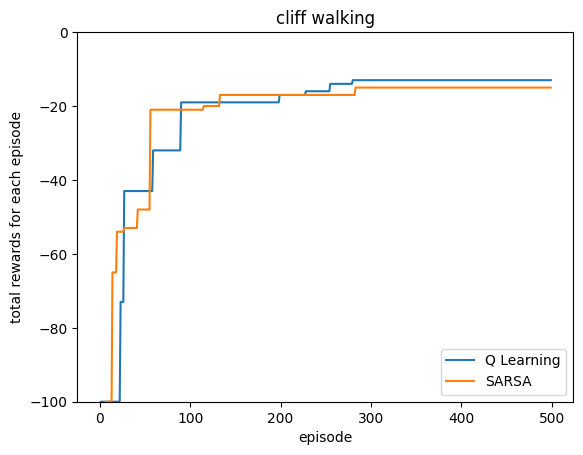

In [147]:
plt.plot(range(len(q_learning_agent.total_reward_log)), np.array(q_learning_agent.total_reward_log), label='Q Learning')
plt.plot(range(len(sarsa_agent.total_reward_log)), np.array(sarsa_agent.total_reward_log),label='SARSA')
# plt.yscale('log')
plt.ylim(-100, 0)
plt.legend(loc='lower right')
plt.title('cliff walking')
plt.xlabel('episode')
plt.ylabel('total rewards for each episode')
plt.savefig('cliff_walking.png')

In [97]:
q_learning_agent.Q

defaultdict(<function __main__.QLearningAgent.learn.<locals>.<lambda>()>,
            {36: [-7.458134171670977,
              -103.7328608628743,
              -7.661030905741677,
              -7.672485215453196],
             24: [-7.280995481960408,
              -7.1757046351899785,
              -7.636787965090827,
              -7.426617682065514],
             12: [-7.0599401110122235,
              -7.067338548430502,
              -7.068168516501994,
              -7.0512485626725345],
             0: [-6.907170666421398,
              -6.917689777296028,
              -6.918486141161367,
              -6.927180597666806],
             1: [-6.75917531348901,
              -6.771870185101477,
              -6.758038774713594,
              -6.756916289809723],
             2: [-6.570580614014949,
              -6.543960696093696,
              -6.602848496699408,
              -6.578127599359067],
             3: [-6.32280722765478,
              -6.277165836939375,
           